In [1]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import matplotlib as mpl
from matplotlib import pyplot as plt

from one.api import ONE
from psyfun import io, plots, atlas
from psyfun.config import *

# Database query

Run scrip to fetch data

In [2]:
%run -i fetch_data.py -a

Fetching sessions...


  4%|▍         | 2/45 [00:00<00:06,  6.61it/s]

  7%|▋         | 3/45 [00:00<00:09,  4.59it/s]

 11%|█         | 5/45 [00:02<00:25,  1.59it/s]local md5 mismatch on dataset: mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_taskSettings.raw.json
(S3) C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\ZFM-08457\2025-03-20\001\raw_task_data_02\_iblrig_taskSettings.raw.json: 100%|██████████| 4.00k/4.00k [00:00<00:00, 15.1kB/s]
local md5 mismatch on dataset: mainenlab/Subjects/ZFM-08457/2025-03-20/001/raw_task_data_02/_iblrig_stimPositionScreen.raw.csv
(S3) C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\ZFM-08457\2025-03-20\001\raw_task_data_02\_iblrig_stimPositionScreen.raw.csv: 100%|██████████| 22.3k/22.3k [00:00<00:00, 74.4kB/s]
  0%|          | 0/45 [00:00<?, ?it/s]c:\Users\marti\Documents\mainen\psychedelics\psyfun\io.py:300: UserWarning: No entries in 'recordings.csv' for 9f420fcf-bc94-458b-afa0-c64b626e7764
  warnings.warn(f"No entries in 'recordings.csv' for {series['eid']}")
c:\Users\marti\Document

Fetching probe insertions...


100%|██████████| 83/83 [00:06<00:00, 13.47it/s]


Fetching unit info and spike times...


  1%|          | 1/83 [00:00<00:29,  2.75it/s]

2025-06-20 15:26:46 WARNING  one.py:360  Histology tracing for probe01 does not exist. No channels for probe01


  1%|          | 1/83 [00:02<03:01,  2.21s/it]


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'data/spikes.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

In [6]:
%run -i fetch_data.py -i

Fetching probe insertions...


100%|██████████| 83/83 [00:00<00:00, 680.41it/s]


In [7]:
%run -i fetch_data.py -t

Loading insertions from metadata/insertions.pqt
Fetching unit info and spike times...


  0%|          | 0/83 [00:00<?, ?it/s]

  1%|          | 1/83 [00:01<01:32,  1.13s/it]

2025-06-20 15:31:33 WARNING  one.py:360  Histology tracing for probe01 does not exist. No channels for probe01


  1%|          | 1/83 [00:02<03:33,  2.60s/it]


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'data/spikes.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

Or do it manually with the function in psyfun.io

In [11]:
# Instantiate database connection
one = ONE()

# Query the database for all sessions associated with this project
# df_sessions = io.fetch_sessions(one, save=True)

# Query the database for all probe insertions associated with this project
# df_insertions = io.fetch_insertions(one, save=True)

Or load session and insertion info from file if already downloaded

In [8]:
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

In [9]:
df_sessions[['eid', 'subject', 'start_time']]

,eid,subject,start_time
0,58ca39c5-e27f-43c4-8516-2ccc4fe88042,SQL-15020,2023-03-21T11:45:48.885186
1,7149e0fc-a52d-4e93-849c-edc22d54e7a5,SQL-15020,2023-03-28T12:16:34.328991
2,debe9833-5c26-4d9e-89ba-c63e07e1db10,SQL-15020,2023-04-04T11:26:16.745718
3,1bc4aea6-c6fa-4cb8-882f-ea1cc4a12667,ZFM-05486,2022-12-07T16:04:11.918382
4,996f3585-b804-4a3d-878a-1c15d708962b,ZFM-05486,2022-12-15T17:50:45.692961
5,98317b26-72d6-4805-9a68-beb7d37f955c,ZFM-05496,2022-12-08T14:47:41.144473
6,2583567d-cd2a-485a-8d79-85aa619e1ce2,ZFM-05496,2022-12-15T12:59:46.966168
7,547a8c9a-be6b-4306-8a9a-c154096693ff,ZFM-05725,2023-01-24T12:21:32.228797
8,8dfd9963-25e5-4f63-8f91-5b27a5852628,ZFM-05725,2023-01-31T15:07:25.758509
9,a1d9a3a6-873c-47fe-9350-6c87876a5669,ZFM-05725,2023-02-07T15:31:40.321474


# Quality control

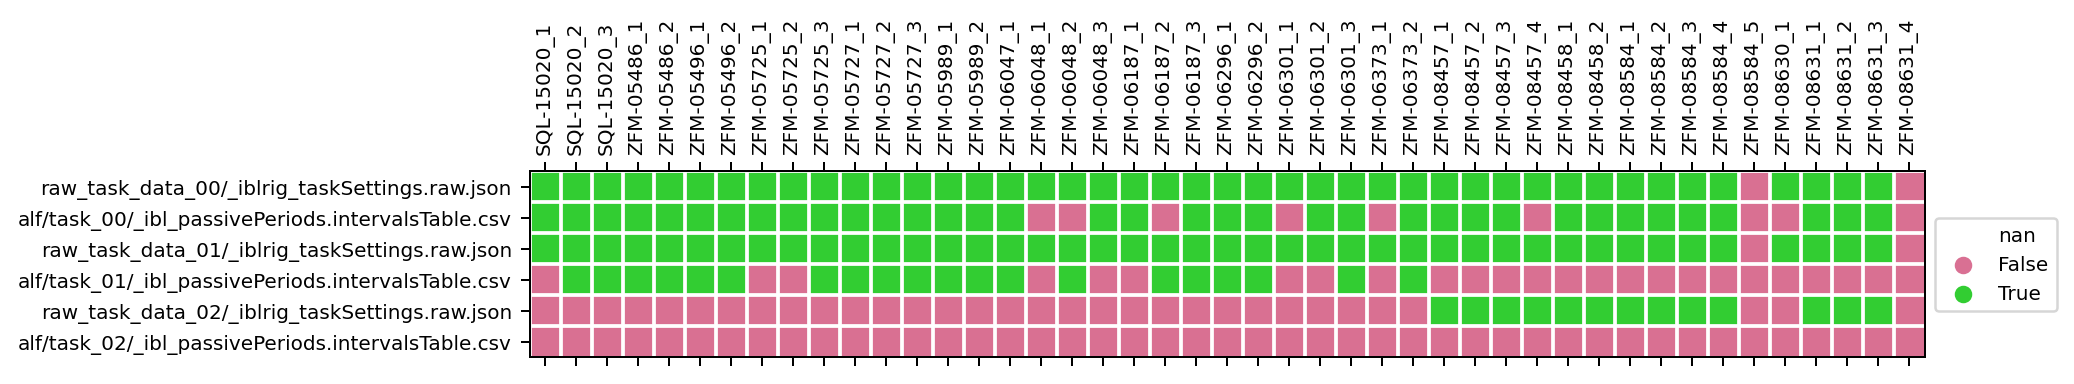

In [10]:
# Check which task datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['task'], qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

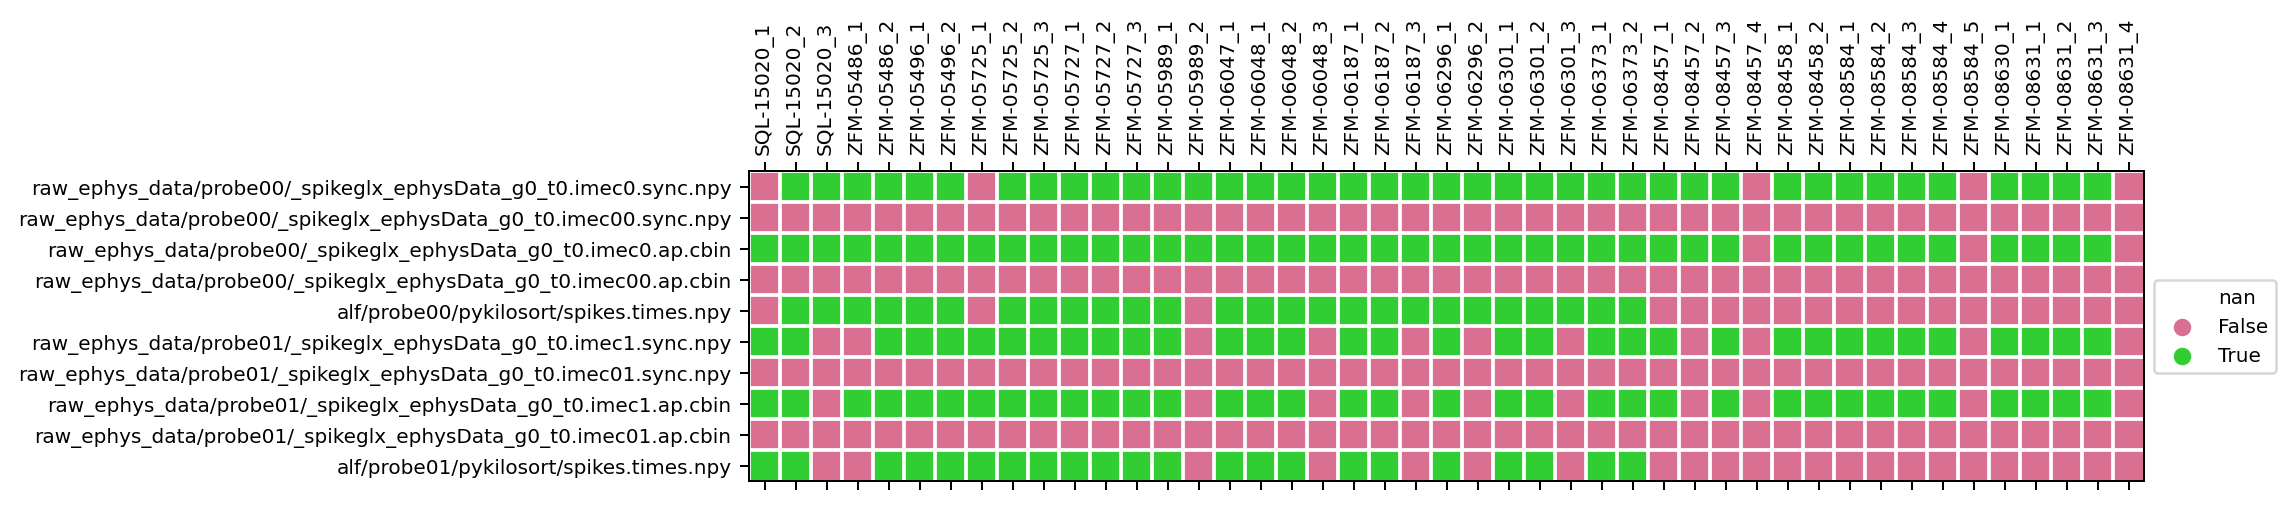

In [11]:
# Check which ephys datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['ephys'], qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

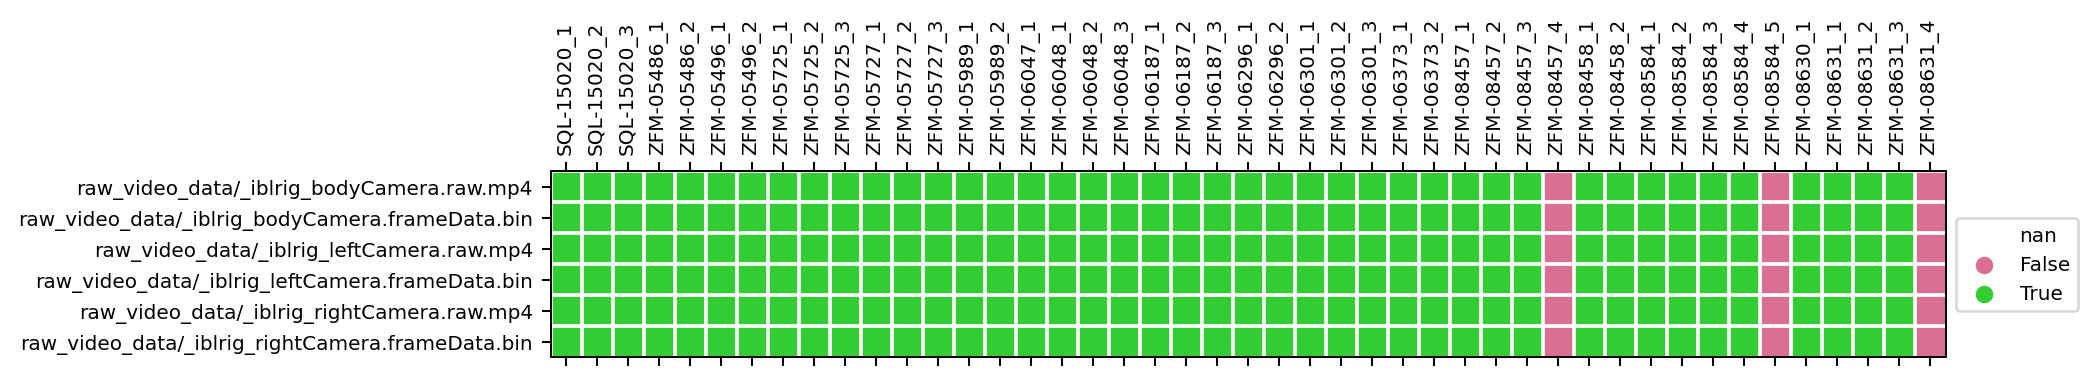

In [25]:
# Check which video datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['video'],  qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

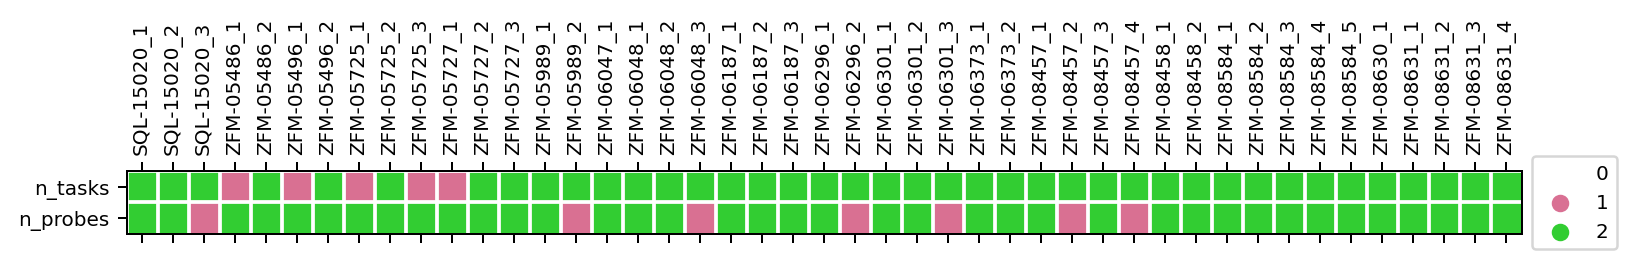

In [13]:
# Check which sessions have the appropriate number of probes and tasks
qc_columns = ['n_tasks', 'n_probes']
qcval2num = {0: 0., 1: 0.1, 2: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

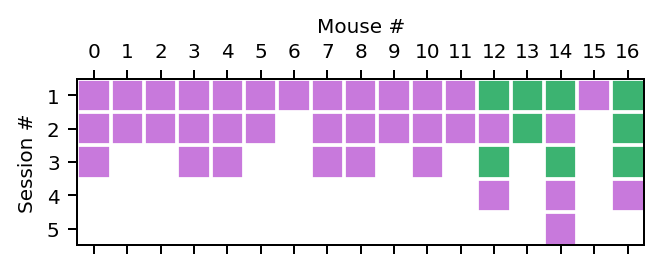

In [14]:
# Check which sessions have all the expected raw data
from matplotlib import colors
cmap = colors.LinearSegmentedColormap.from_list(
    'rec_type',
    [(0., 'white'), (0.01, LSDCOLOR), (1., CONTROLCOLOR)],
)
sessions_pivot = df_sessions.pivot(columns='session_n', index='subject', values='control_recording')
sessions_pivot = sessions_pivot.rename_axis(None, axis='columns')
ax = plots.qc_grid(sessions_pivot, qcval2num={np.nan: 0., False: 0.01, True: 1.}, cmap=cmap)
ax.set_xticklabels(sessions_pivot.index)
# ax.tick_params(axis='x', rotation=90)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_xticklabels(range(len(ax.get_xticklabels())))
ax.set_ylabel('Session #')
ax.set_xlabel('Mouse #')
ax.xaxis.set_label_position('top')
# ax.get_figure().set_figwidth(10)
legend = ax.get_legend()
legend.set_visible(False)
# for label, text in zip(legend.get_texts(), ['', 'LSD', 'Saline']):
#     label.set_text(text)
plots.set_plotsize(w=8, h=4)

In [15]:
legend.set_visible(False)

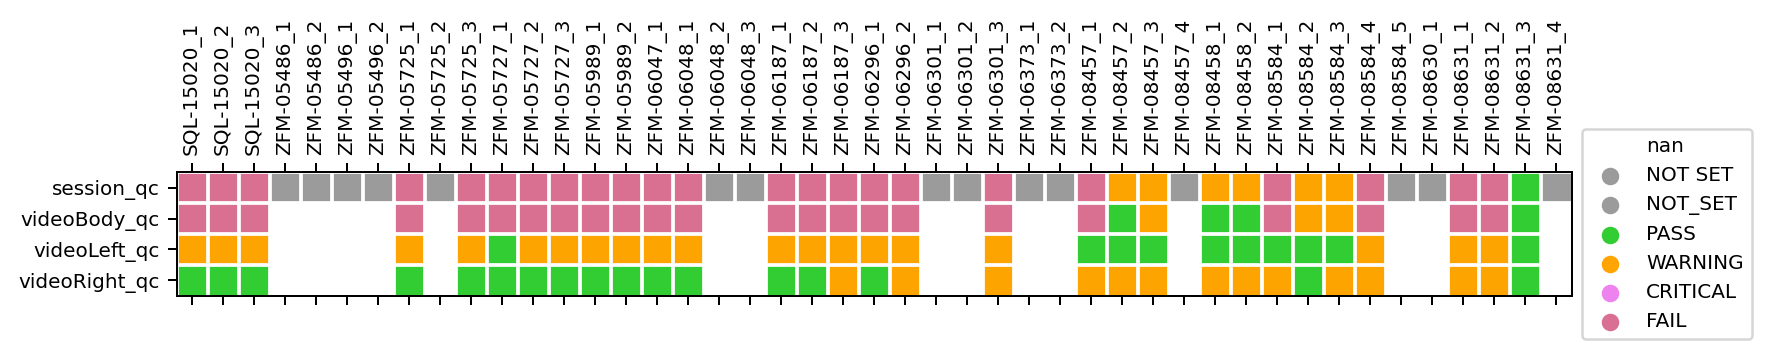

In [16]:
# Plot QC summary for the task and video
qc_columns = ['session_qc', 'videoBody_qc', 'videoLeft_qc', 'videoRight_qc']
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, xticklabels=xticklabels)
ax.get_figure().set_figwidth(10)

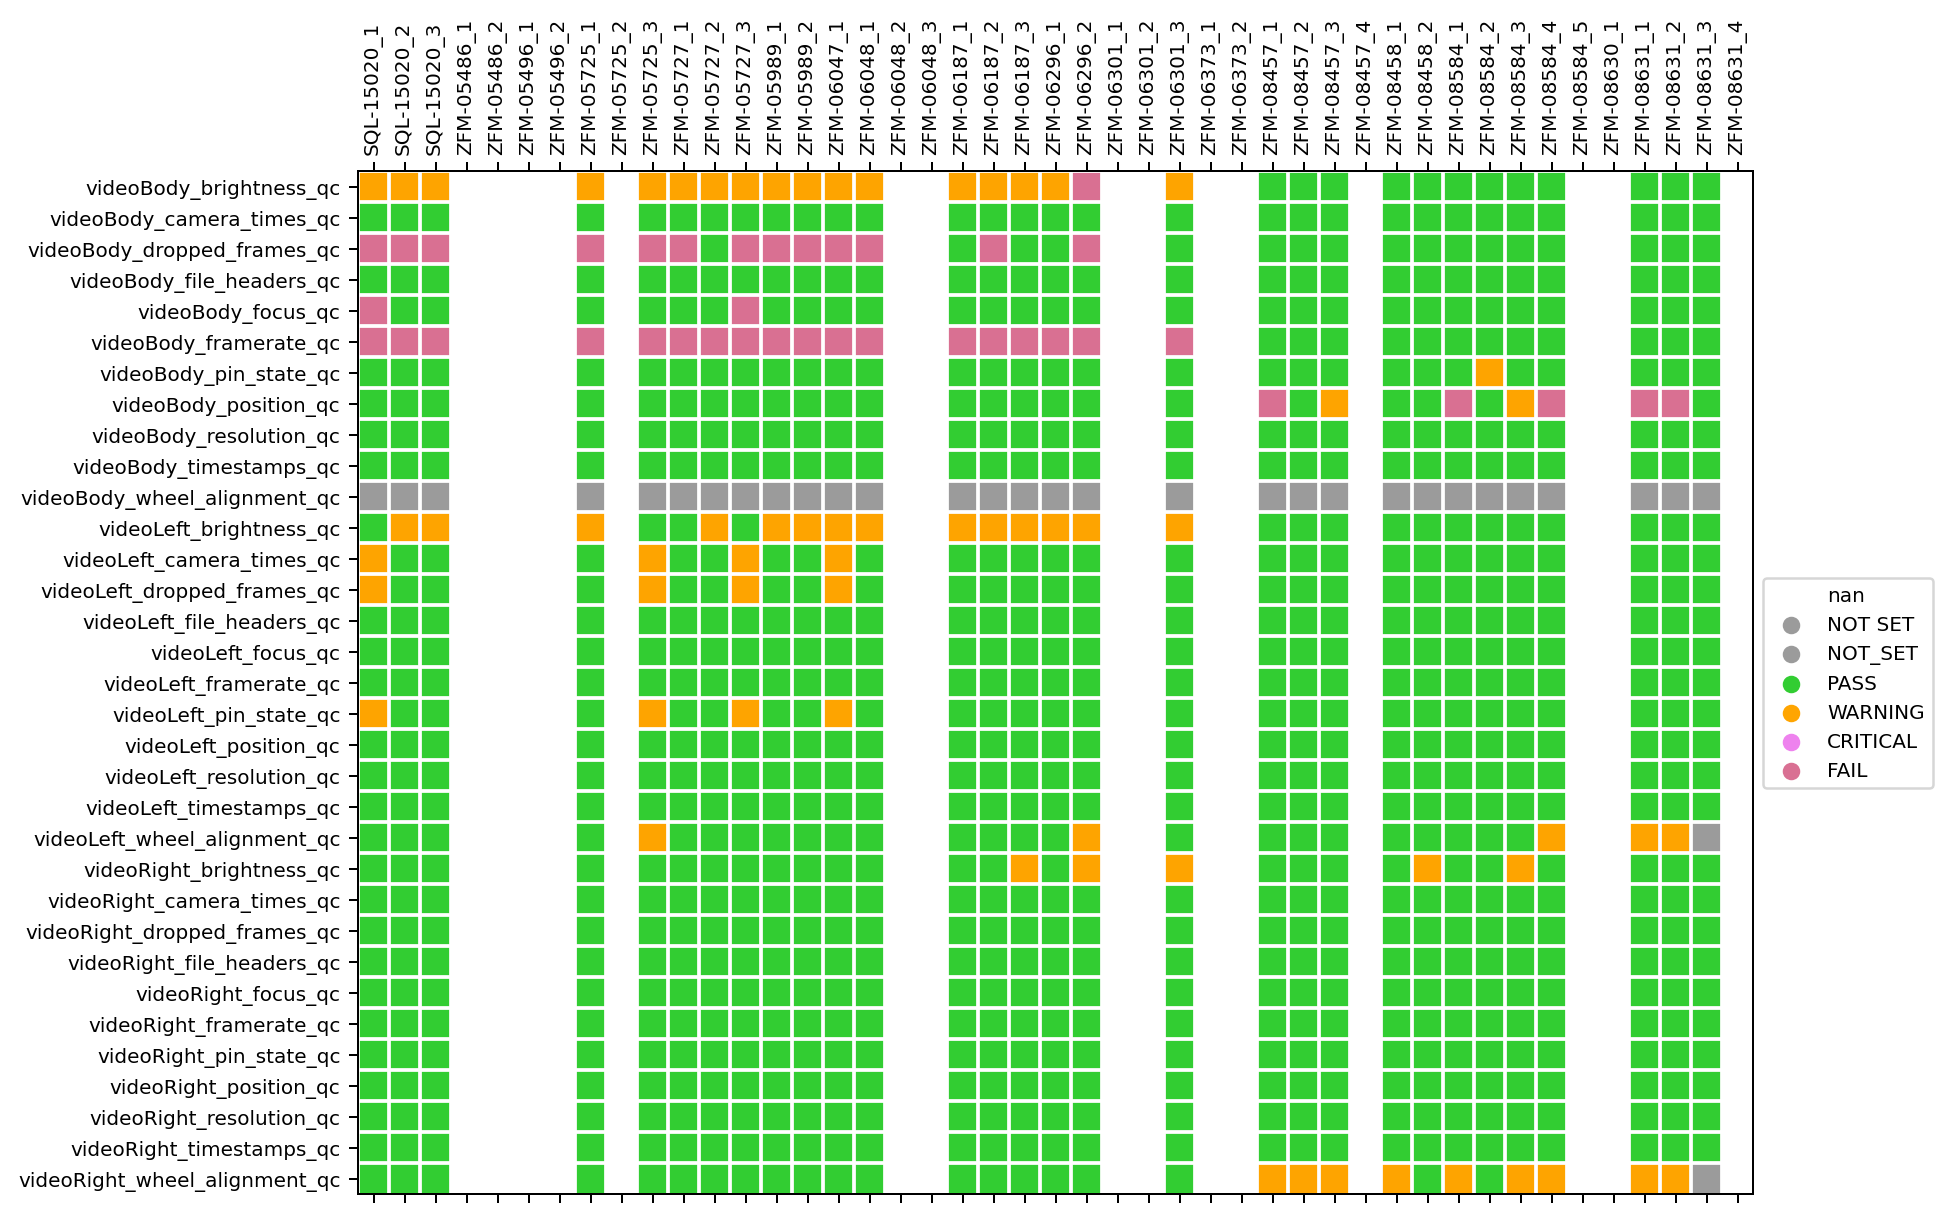

In [17]:
# Plot detailed video QC for each session
fig, ax = plt.subplots(figsize=(6, 8))
qc_columns = [col for col in df_sessions.columns if ('qc' in col) & (col.count('_') > 1)]
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, ax=ax, xticklabels=xticklabels)
ax.get_figure().set_figwidth(10)

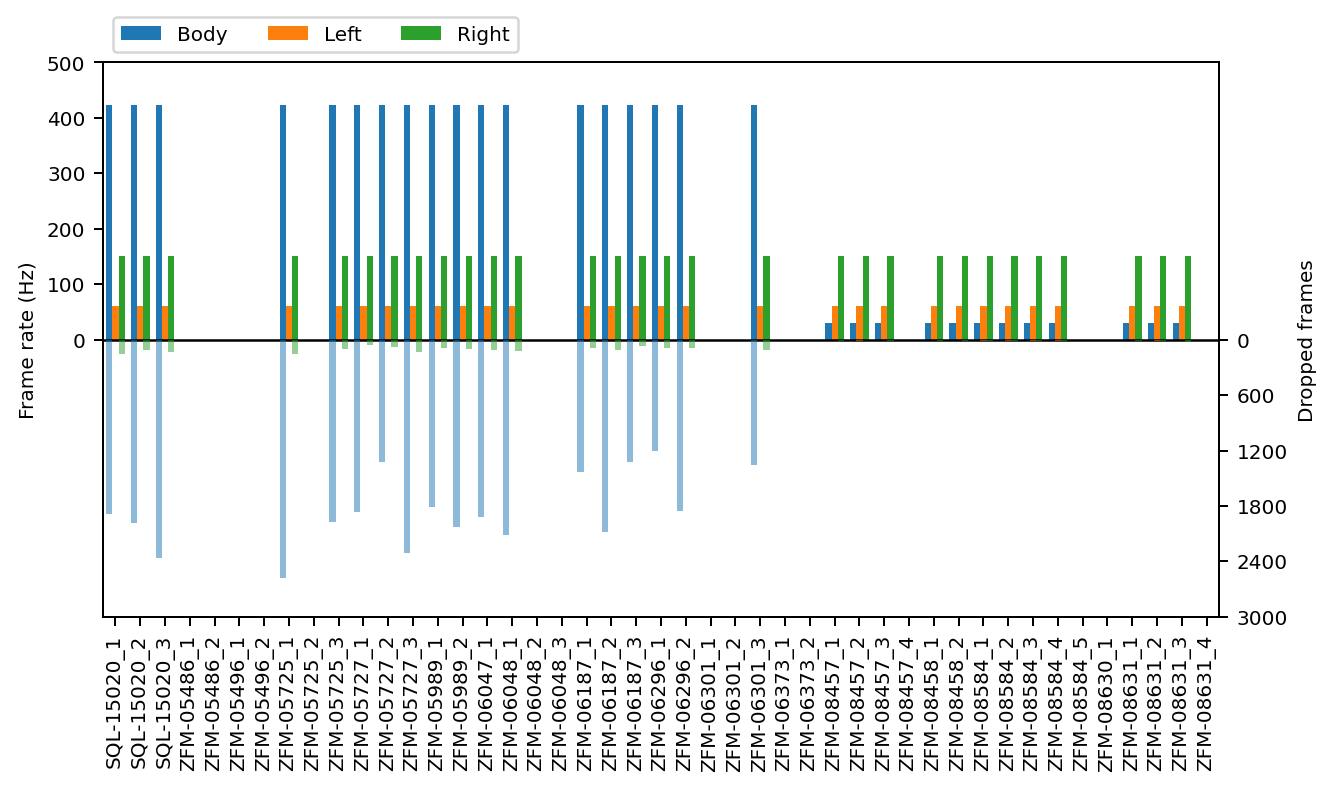

In [18]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

KeyError: 'n_units'

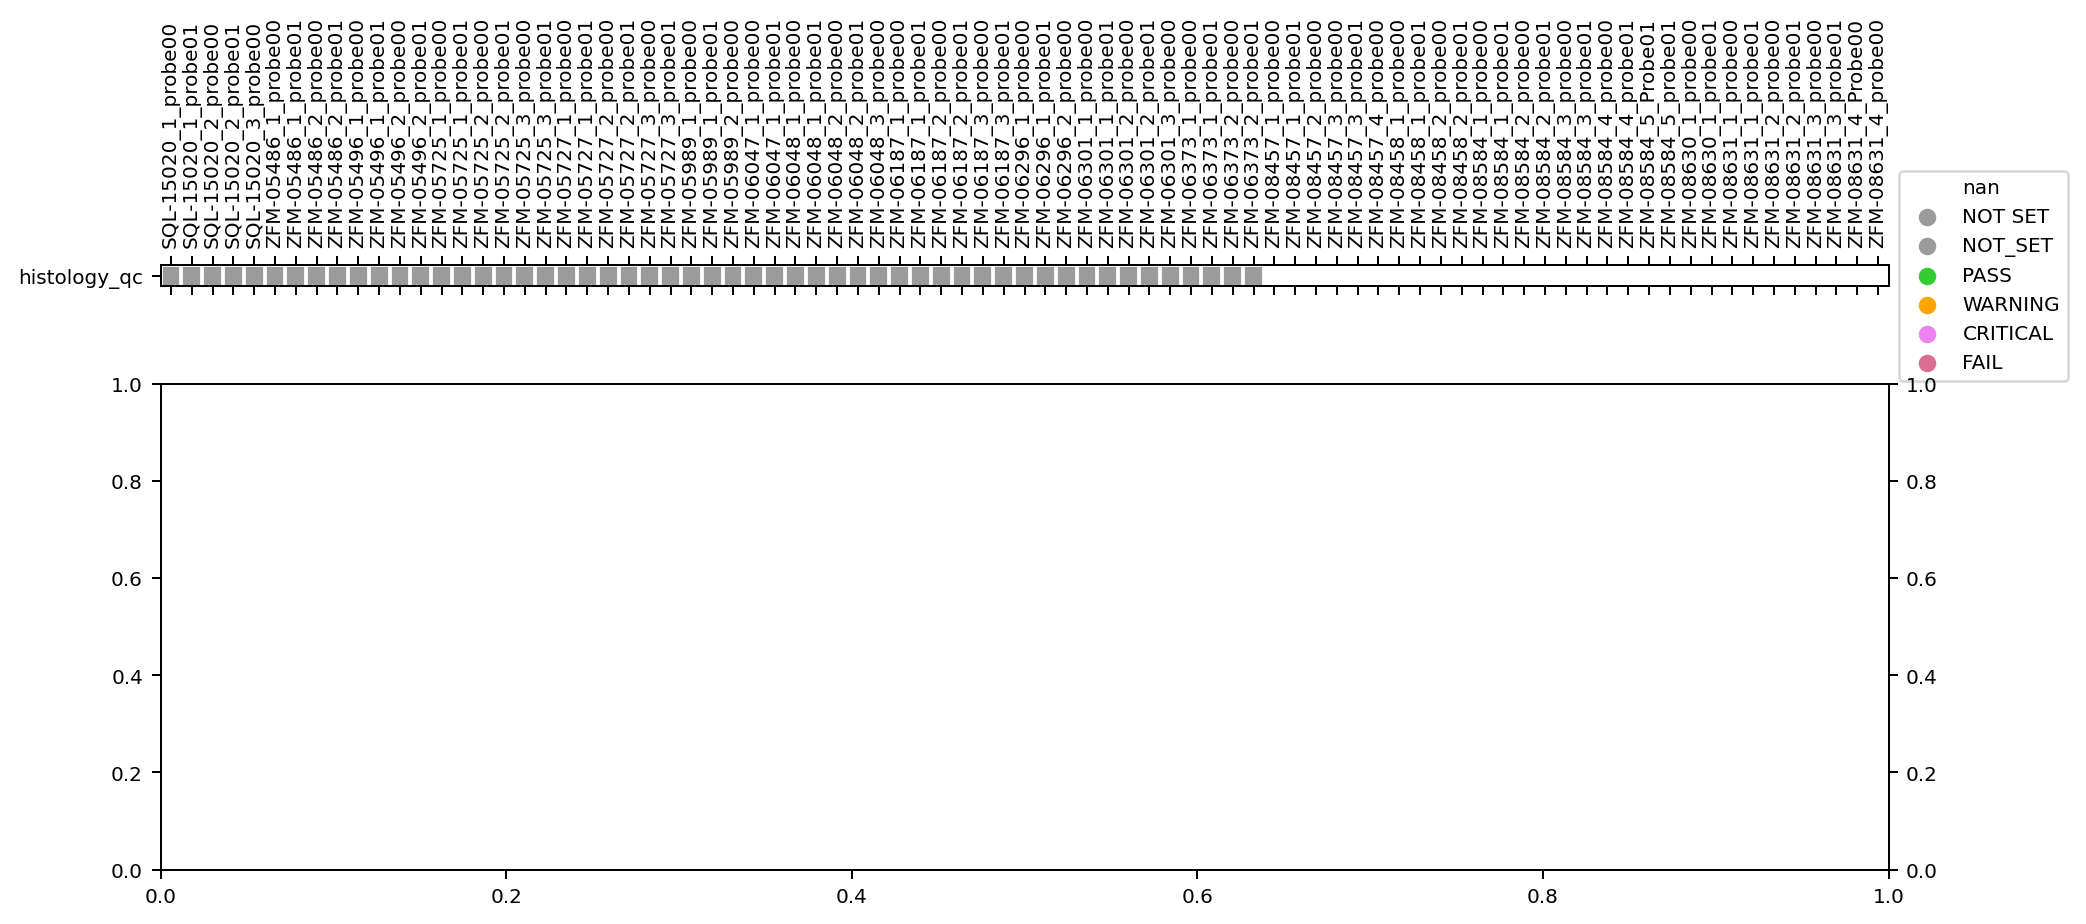

In [19]:
# Plot detailed ephys QC for ech session/probe
fig = plt.figure(figsize=(12, 6))
axs = [
    fig.add_axes([0.1, 0.5, 0.8, 0.3]),
    fig.add_axes([0.1, 0.1, 0.8, 0.45])
]

# Sort by subject
df_insertions = df_insertions.sort_values(['subject', 'session_n', 'probe'])

# QC grid plot
qc_columns = [col for col in df_insertions.columns if col.endswith('_qc')]
xticklabels = ['subject', 'session_n', 'probe']
axs[0] = plots.qc_grid(df_insertions, qc_columns, ax=axs[0], xticklabels=xticklabels)


# Bar plots for N units and firing rates
ax2 = axs[1].twinx()
xpos = np.arange(len(df_insertions))
offests = [-0.15, 0.15]
alphas = [0.5, 1.]
units_cols = ['n_units', 'n_units_qc_pass']
rate_cols = ['firing_rate_max', 'firing_rate_median']
for offset, units_col, rate_col, alpha in zip(offests, units_cols, rate_cols, alphas):
    n_units = df_insertions[units_col]
    axs[1].bar(xpos + offset, n_units, width=0.3, color='C0', alpha=alpha)
    firing_rate = df_insertions[rate_col]
    ax2.bar(xpos + offset, -1 * np.log10(firing_rate),  width=0.3, color='C0', alpha=alpha)
axs[1].set_xlim([-0.5, len(df_insertions) - 0.5])
axs[1].set_ylim([-2000, 2000])
axs[1].set_yticks(np.linspace(0, 2000, 5))
axs[1].set_ylabel('N units')
ax2.set_ylim([-3, 3])
ax2.set_yticks(-1 * np.linspace(0, 3, 4))
ax2.set_yticklabels(f'$10^{tick}$' for tick in np.linspace(0, 3, 4).astype(int))
ax2.set_ylabel('Firing rate (Hz)')
axs[1].axhline(0, color='black', lw=1)
axs[1].set_xticks(np.arange(len(df_insertions)))
axs[1].set_xticklabels(df_insertions.apply(lambda x: f"{x['subject']}_{x['session_n']}_{x['probe']}", axis='columns'))
axs[1].tick_params(axis='x', rotation=90)

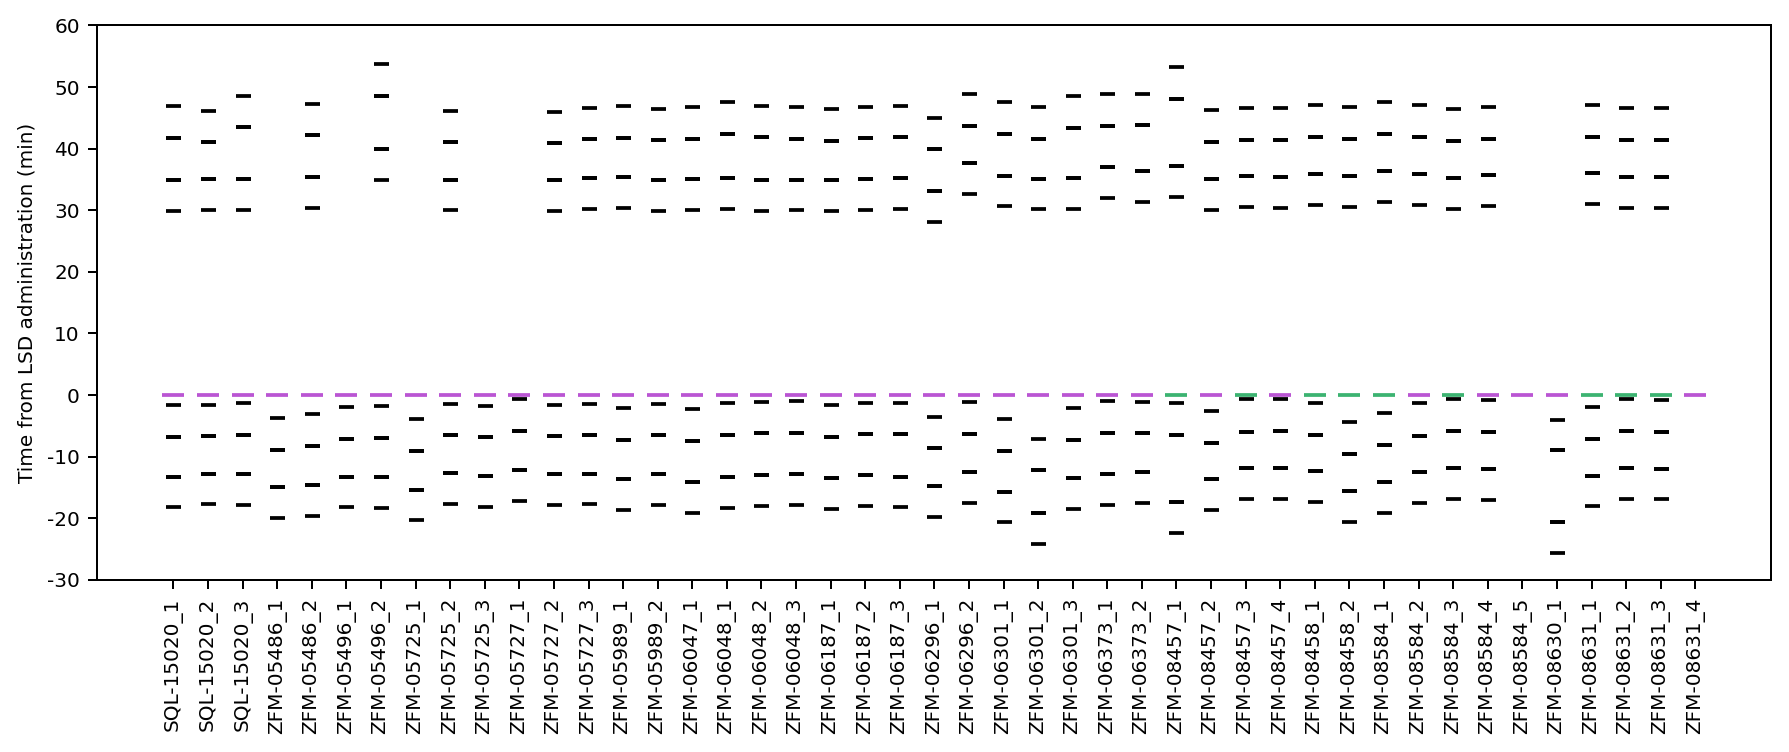

In [20]:
# Plot protocol timings for all sessions
epochs = ['spontaneous', 'rfm', 'replay']
fig, ax = plt.subplots(figsize=(12, 4))
for idx, session in df_sessions.iterrows():
    t0 = session['LSD_admin']
    if session['control_recording']:
        ax.scatter(idx, 0, marker='_', s=80, color=CONTROLCOLOR)
    else:
        ax.scatter(idx, 0, marker='_', s=80, color=LSDCOLOR)
    for task in ['task00', 'task01']:
        for epoch in epochs:
            ax.scatter(idx, session[f'{task}_{epoch}_start'] - t0, marker='_', color='black')
            ax.scatter(idx, session[f'{task}_{epoch}_stop'] - t0, marker='_', color='black')
ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-30, 60, 10) * 60)
ax.set_yticklabels(np.linspace(-30, 60, 10).astype(int))
ax.set_ylabel('Time from LSD administration (min)')
fig.savefig('LSD_sessions.png')

# Fetch spike data

In [21]:
%run -i fetch_data.py -t

Loading insertions from metadata/insertions.pqt
Fetching unit info and spike times...


  1%|          | 1/83 [00:01<02:12,  1.62s/it]

2025-06-20 15:43:23 WARNING  one.py:360  Histology tracing for probe01 does not exist. No channels for probe01


  1%|          | 1/83 [00:03<04:39,  3.41s/it]


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'data/spikes.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

In [22]:
# Instantiate database connection
one = ONE()

# Fetch spike data for all recordings in df_insertions
fetch_spikes = True
spike_file = paths['spikes'] if fetch_spikes else ''
histology = 'traced'
# df_units = io.fetch_unit_info(one, df_insertions, uinfo_file=paths['units'], spike_file=spike_file, histology=histology)

In [23]:
# Load cluster info from file, keep only good units
df_units = pd.read_parquet(paths['units']).query('ks2_label =="good"')
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/units.pqt'

In [18]:
eids = df_sessions['eid'].to_list()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# # Load spike times for good units
# uuids = df_unitquery['uuid'].tolist()
# df_spiketimes = io.load_units(paths['spikes'], uuids)
# # Join spike times with unit info
# df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_units = pd.merge(df_unitquery, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_units = df_units[[col for col in df_units.columns if not col.endswith('_x') or col.endswith('_y')]]

/tmp/ipykernel_27996/14490598.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_counts = df_units.query('control_recording == False').groupby('coarse_region').apply(len).sort_values(ascending=False)


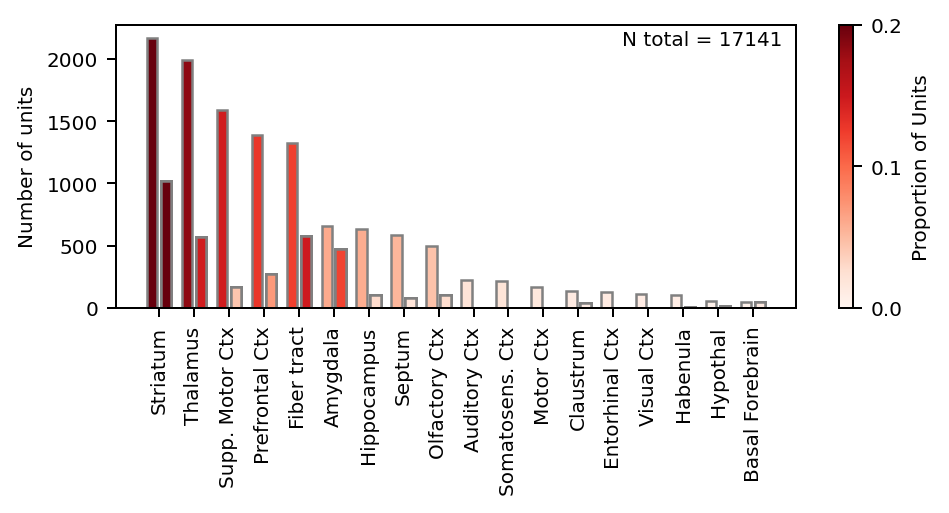

In [21]:
fig, ax = plt.subplots()
cmap = cmaps['n_units']

region_counts = df_units.query('control_recording == False').groupby('coarse_region').apply(len).sort_values(ascending=False)

n_regions = len(region_counts)
props = region_counts / region_counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(n_regions) - 0.2, region_counts, width=0.3, fc=colors, ec='gray')
ax.set_xticks(np.arange(n_regions))
ax.set_xticklabels(region_counts.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of units')
ax.text(0.98, 0.98, f'N total = {len(df_units)}', fontsize=plots.LABELFONTSIZE, ha='right', va='top', transform=ax.transAxes)

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 0.2), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')
cbar.set_ticks([0, 0.1, 0.2])

for xpos, region in enumerate(region_counts.index):
    n_units = df_units.query('(control_recording == True) & (coarse_region == @region)').apply(len)
    color = cmap(n_units / len(df_units.query('(control_recording == True)')) / props.max())
    ax.bar(xpos + 0.2, n_units, width=0.3, color=color, ec='gray')

plots.set_plotsize(w=12, h=4)

In [24]:
# Plot distribution of units across brain regions
from iblutil.numerical import ismember
from iblatlas.atlas import AllenAtlas, BrainRegions
import iblatlas.plots as anatomyplots
atlas = AllenAtlas(res_um=50)
regions = BrainRegions()
from psyfun.config import ap_coords

Downloading: C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\histology\ATLAS\Needles\Allen\average_template_50.nrrd Bytes: 5346363


100%|██████████| 5.098689079284668/5.098689079284668 [00:01<00:00,  4.74it/s]


Downloading: C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\histology\ATLAS\Needles\Allen\annotation_50.nrrd Bytes: 880845


100%|██████████| 0.8400392532348633/0.8400392532348633 [00:00<00:00,  1.61it/s]


/tmp/ipykernel_32778/1459586891.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_counts = df_uinfo.groupby('region').apply(len).sort_values(ascending=False)


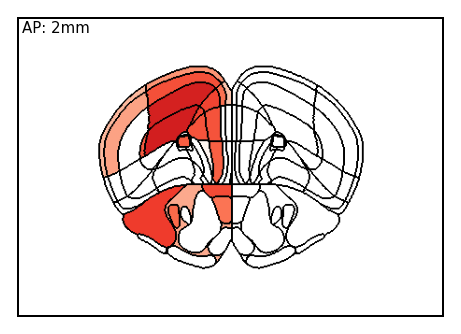

In [86]:
region_counts = df_uinfo.groupby('region').apply(len).sort_values(ascending=False)
ap_coord = 2
# fig, ax, cbar = anatomyplots.plot_scalar_on_slice(
#     region_counts.index, 
#     np.log10(region_counts.values),
#     coord=ap_coord * 1000,  # in um
#     background='boundary',
#     atlas=atlas,
#     clevels=[0, 4],
#     cmap=cmap,
#     show_cbar=True,
# )
fig, ax = anatomyplots.plot_scalar_on_slice(
    region_counts.index, 
    np.log10(region_counts.values),
    coord=ap_coord * 1000,  # in um
    background='boundary',
    atlas=atlas,
    clevels=[0, 4],
    cmap=cmap,
    show_cbar=False,
)
ax.text(0.01, 0.95, f'AP: {ap_coord}mm', fontsize=plots.LABELFONTSIZE, transform=ax.transAxes)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# ax_pos = ax.get_position()  # returns [left, bottom, width, height]
# cbar_pos = cbar.ax.get_position()
# cbar.ax.set_position([cbar_pos.x0, ax_pos.y0, cbar_pos.width, ax_pos.height])
# cbar.set_ticks(np.linspace(0, 4, 5))
# cbar.set_ticklabels(['$10^{%d}$' % tick for tick in np.linspace(0, 4, 5)])
# cbar.set_label('N units')

plots.set_plotsize(w=6, ax=ax)

In [9]:
## TODO: normalize contribution of units by volume of region

# Control data

In [25]:
df_bwm = io.fetch_BWM_task_starts(one)

100%|███████████████████████████████████████| 1068/1068 [02:23<00:00,  7.45it/s]


In [134]:
df_bwm = pd.read_csv('metadata/BWM_task_starts.csv')

Sessions with pre-task period > 5.00min: 26


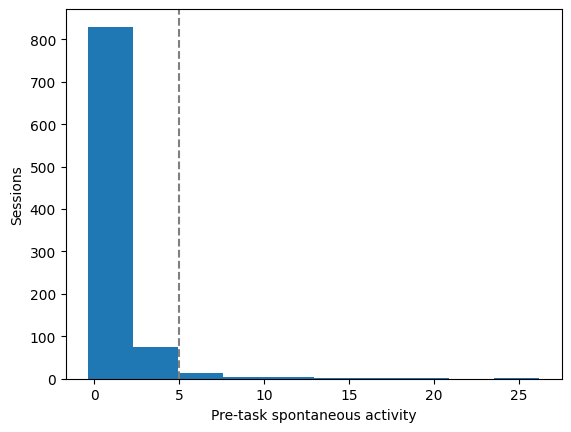

In [135]:
cutoff = 300 

fig, ax = plt.subplots()
ax.hist(df_bwm['task_start'] / 60)
ax.axvline(cutoff / 60, ls='--', color='gray')
ax.set_ylabel('Sessions')
ax.set_xlabel('Pre-task spontaneous activity')

df_controls = df_bwm.query('task_start > @cutoff')
print(f'Sessions with pre-task period > {cutoff / 60:.2f}min: {len(df_controls)}')

In [5]:
df_insertions_bwm = io.fetch_BWM_insertions(one, df_controls)

100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 681.65it/s]


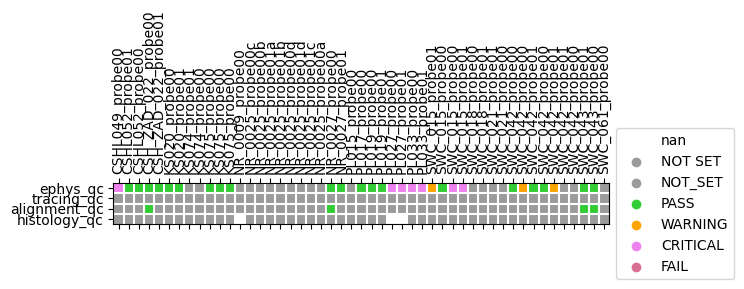

In [6]:
# QC grid plot
qc_columns = [col for col in df_insertions_bwm.columns if col.endswith('_qc')]
xticklabels = ['subject', 'probe']
ax = plots.qc_grid(df_insertions_bwm, qc_columns, xticklabels=xticklabels)

In [5]:
df_insertions_bwm = pd.read_csv(paths['BWM_insertions'])

In [10]:
len(df_insertions_bwm['eid'].unique())

26

In [4]:
df_uinfo = io.fetch_unit_info(one, df_insertions_bwm, uinfo_file=paths['BWM_units'], spike_file=paths['BWM_spikes'])

  0%|                                                    | 0/49 [00:00<?, ?it/s]

alf/probe00



  2%|▉                                           | 1/49 [00:05<04:43,  5.91s/it]

alf/probe01/pykilosort



100%|███████████████████████████████████████| 1031/1031 [00:36<00:00, 28.61it/s]


alf/probe01



  4%|█▊                                          | 2/49 [01:01<27:25, 35.00s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 771/771 [00:29<00:00, 26.30it/s]


alf/probe00



  6%|██▋                                         | 3/49 [01:41<28:45, 37.52s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 763/763 [00:31<00:00, 24.27it/s]


alf/probe00



  8%|███▌                                        | 4/49 [02:32<32:10, 42.91s/it]

alf/probe01/pykilosort



 10%|████▍                                       | 5/49 [03:23<33:31, 45.71s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 309/309 [00:26<00:00, 11.72it/s]


alf/probe00



 12%|█████▍                                      | 6/49 [03:56<29:42, 41.46s/it]

alf/probe01



100%|█████████████████████████████████████████| 827/827 [00:08<00:00, 93.92it/s]


alf/probe01/pykilosort



 14%|██████▎                                     | 7/49 [04:17<24:11, 34.55s/it]

alf/probe01/pykilosort



 16%|███████▏                                    | 8/49 [04:37<20:34, 30.12s/it]

alf/probe00/pykilosort



 18%|████████                                    | 9/49 [04:41<14:33, 21.83s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-05"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


alf/probe00/pykilosort



 20%|████████▊                                  | 10/49 [04:47<10:56, 16.84s/it]

alf/probe00/pykilosort



 22%|█████████▋                                 | 11/49 [04:51<08:18, 13.11s/it]

alf/probe00/pykilosort



 24%|██████████▌                                | 12/49 [04:58<06:58, 11.31s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0009/2021-08-11/002/alf/probe00/pykilosort/clusters.uuids.csv

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub


alf/probe00/pykilosort



 27%|███████████▍                               | 13/49 [05:04<05:44,  9.58s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.uuids.csv
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.channels.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) 

alf/probe00c/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloa

alf/probe00b/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

 31%|█████████████▏                             | 15/49 [05:28<05:59, 10.58s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/c

alf/probe01a/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe01b/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00d/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe01d/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloa

alf/probe01c/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00a/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00/pykilosort



 45%|███████████████████▎                       | 22/49 [07:16<09:05, 20.19s/it]

alf/probe01/pykilosort



 47%|████████████████████▏                      | 23/49 [07:59<11:42, 27.01s/it]local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.depths.npy
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.channels.npy
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.uuids.csv

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downlo

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe00/pykilosort



 51%|█████████████████████▉                     | 25/49 [08:53<11:13, 28.07s/it]

alf/probe00/pykilosort



 53%|██████████████████████▊                    | 26/49 [08:58<08:04, 21.06s/it]

alf/probe01/pykilosort



 55%|███████████████████████▋                   | 27/49 [09:00<05:38, 15.38s/it]local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.channels.npy
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.uuids.csv
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.depths.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downlo

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe01/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloa

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe01/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloa

alf/probe01



100%|███████████████████████████████████████| 206/206 [00:00<00:00, 1062.94it/s]


alf/probe01/pykilosort



 65%|████████████████████████████               | 32/49 [09:59<03:10, 11.19s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 381/381 [00:04<00:00, 84.47it/s]


alf/probe00



 67%|████████████████████████████▉              | 33/49 [10:08<02:52, 10.75s/it]

alf/probe00/pykilosort



100%|████████████████████████████████████████| 224/224 [00:01<00:00, 157.82it/s]


alf/probe00



 69%|█████████████████████████████▊             | 34/49 [10:17<02:33, 10.22s/it]

alf/probe01



100%|████████████████████████████████████████| 290/290 [00:00<00:00, 501.03it/s]


alf/probe01/pykilosort



 71%|██████████████████████████████▋            | 35/49 [10:21<01:57,  8.40s/it]

alf/probe00/pykilosort



100%|██████████████████████████████████████████| 63/63 [00:00<00:00, 148.05it/s]


alf/probe00



 73%|███████████████████████████████▌           | 36/49 [10:28<01:43,  7.97s/it]

alf/probe01/pykilosort



100%|█████████████████████████████████████████| 341/341 [00:04<00:00, 72.95it/s]


alf/probe01



 76%|████████████████████████████████▍          | 37/49 [10:37<01:38,  8.17s/it]

alf/probe01



100%|██████████████████████████████████████████| 82/82 [00:00<00:00, 998.49it/s]


alf/probe01/pykilosort



 78%|█████████████████████████████████▎         | 38/49 [10:43<01:21,  7.40s/it]

alf/probe00



100%|████████████████████████████████████████| 176/176 [00:00<00:00, 992.09it/s]


alf/probe00/pykilosort



 80%|██████████████████████████████████▏        | 39/49 [10:46<01:01,  6.15s/it]

alf/probe00



100%|██████████████████████████████████████| 1370/1370 [00:06<00:00, 226.00it/s]


alf/probe00/pykilosort



 82%|███████████████████████████████████        | 40/49 [11:47<03:23, 22.64s/it]

alf/probe00



100%|████████████████████████████████████████| 150/150 [00:00<00:00, 217.75it/s]


alf/probe00/pykilosort



 84%|███████████████████████████████████▉       | 41/49 [11:54<02:24, 18.02s/it]

alf/probe01



100%|██████████████████████████████████████████| 91/91 [00:00<00:00, 256.51it/s]


alf/probe01/pykilosort



 86%|████████████████████████████████████▊      | 42/49 [11:57<01:34, 13.56s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 479/479 [00:05<00:00, 81.48it/s]


alf/probe00



 88%|█████████████████████████████████████▋     | 43/49 [12:16<01:30, 15.16s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-05"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


alf/probe01



100%|████████████████████████████████████████| 258/258 [00:00<00:00, 299.47it/s]


alf/probe01/pykilosort



 90%|██████████████████████████████████████▌    | 44/49 [12:21<01:00, 12.08s/it]

alf/probe01



100%|████████████████████████████████████████| 226/226 [00:01<00:00, 169.41it/s]


alf/probe01/pykilosort



 92%|███████████████████████████████████████▍   | 45/49 [12:30<00:44, 11.02s/it]

alf/probe00/pykilosort



 94%|████████████████████████████████████████▎  | 46/49 [12:50<00:41, 13.74s/it]

alf/probe01/pykilosort



100%|███████████████████████████████████████| 1542/1542 [00:31<00:00, 48.61it/s]


alf/probe01/ks2_preproc_tests



100%|██████████████████████████████████████| 1542/1542 [00:09<00:00, 155.16it/s]


alf/probe01



 96%|█████████████████████████████████████████▏ | 47/49 [13:56<00:58, 29.43s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 819/819 [00:15<00:00, 52.68it/s]


alf/probe00



 98%|██████████████████████████████████████████ | 48/49 [14:20<00:27, 27.91s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 361/361 [00:32<00:00, 11.18it/s]


alf/probe00



100%|███████████████████████████████████████████| 49/49 [15:05<00:00, 18.49s/it]


In [8]:
df_uinfo_bwm = pd.read_parquet(paths['BWM_units'])

In [9]:
len(df_uinfo_bwm)

21456

In [149]:
## TODO: check if e.g. intervals table dataset exists
## TODO: ask Olivier to re-extract old task data
for eif in df_uinfo_bwm['eid'].unique():
    details = one.get_details(eid)
    print(details['task_protocol'])

_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5
_iblrig_tasks_ephysChoiceWorld6.2.5


In [152]:
task_settings = one.load_dataset(eid, '_iblrig_taskSettings.raw.json')

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-12/003/raw_behavior_data/_iblrig_taskSettings.raw.json: 100%|█
